<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#自动求梯度" data-toc-modified-id="自动求梯度-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>自动求梯度</a></span><ul class="toc-item"><li><span><a href="#概念" data-toc-modified-id="概念-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>概念</a></span></li><li><span><a href="#Tensor" data-toc-modified-id="Tensor-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Tensor</a></span><ul class="toc-item"><li><span><a href="#梯度" data-toc-modified-id="梯度-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>梯度</a></span></li><li><span><a href="#为何backward要传入同形-Tensor" data-toc-modified-id="为何backward要传入同形-Tensor-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>为何backward要传入同形 Tensor</a></span><ul class="toc-item"><li><span><a href="#实验1" data-toc-modified-id="实验1-1.2.2.1"><span class="toc-item-num">1.2.2.1&nbsp;&nbsp;</span><strong>实验1</strong></a></span></li><li><span><a href="#实验二" data-toc-modified-id="实验二-1.2.2.2"><span class="toc-item-num">1.2.2.2&nbsp;&nbsp;</span><strong>实验二</strong></a></span></li><li><span><a href="#实验三：-再来看看-中断梯度追踪的例子：" data-toc-modified-id="实验三：-再来看看-中断梯度追踪的例子：-1.2.2.3"><span class="toc-item-num">1.2.2.3&nbsp;&nbsp;</span><strong>实验三：</strong> 再来看看 <strong>中断梯度追踪</strong>的例子：</a></span></li></ul></li><li><span><a href="#从投影方面理解-雅可比矩阵-pytorch自动微分" data-toc-modified-id="从投影方面理解-雅可比矩阵-pytorch自动微分-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>从投影方面理解 雅可比矩阵 pytorch自动微分</a></span></li></ul></li></ul></li></ul></div>

# 自动求梯度

## 概念

Tensor是这个包的核心类，将其属性 *.requires_gred* 设置为 True.它将开始追踪在其上的所有操作(这样就可以利用链式法则进行梯度传播了)。完成计算后，可以调用 *.backward()* 来完成所有梯度计算。此时 Tensor的梯度将累积到 *.grad*属性中。

> 注意在y.backward()时，如果y是标量，则不需要为backward()传入任何参数；否则，需要传入一个与y同形的Tensor

如果不想要被继续追踪，可以调用.detach()将其从追踪记录中分离出来，这样就可以防止将来的计算被追踪，这样梯度就传不过去了。此外，还可以用with torch.no_grad()将不想被追踪的操作代码块包裹起来，这种方法在评估模型的时候很常用，因为在评估模型时，我们并不需要计算可训练参数（requires_grad=True）的梯度。
Function是另外一个很重要的类。Tensor和Function互相结合就可以构建一个记录有整个计算过程的有向无环图（DAG）。每个Tensor都有一个.grad_fn属性，该属性即创建该Tensor的Function, 就是说该Tensor是不是 **通过某些运算得到的**，若是，则grad_fn返回一个与这些运算相关的对象，否则是None。

## Tensor


In [2]:
import torch
x = torch.ones(2,2,requires_grad=True)
print(x)
print(x.grad_fn)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
None


In [4]:
y = x + 2
print(y)
print(y.grad_fn)


tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


x是直接创建的，所以没有 grad_fn,而y是通过一个加法操作创建的，所以有 \<AddBackward\>的 grad_fn
像x这种直接创建的称为叶子节点，叶子节点对应的grad_fn是None

In [5]:
print(x.is_leaf, y.is_leaf) # True False


True False


In [6]:
z = y * y * 3
out = z.mean()
print(z, out)


tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)


### 梯度

因为out是一个标量，所以调用backward()时不需要指定求导变量：

In [7]:
out.backward() # 等价于 out.backward(torch.tensor(1.))


现在来看out关于x的梯度 $\frac{d(out)}{dx}$

In [8]:
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


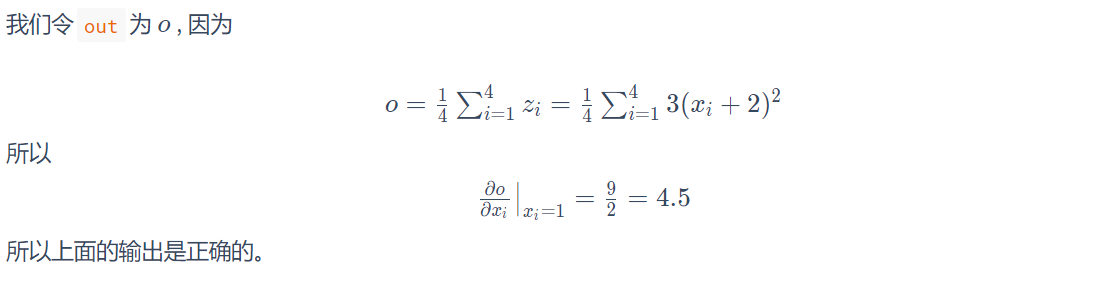

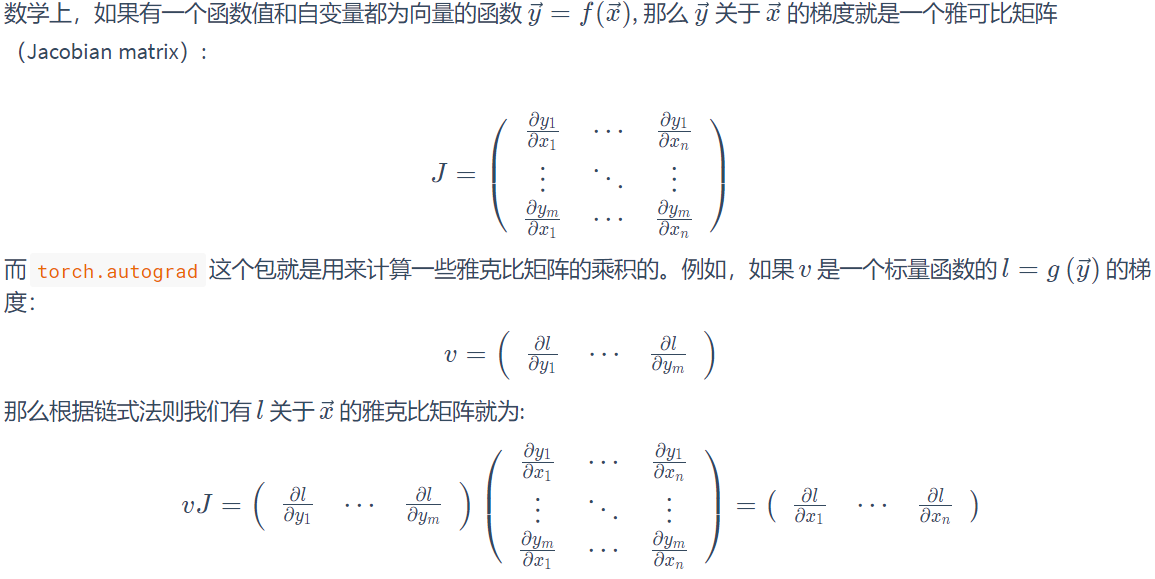

注意：grad在反向传播过程中是累加的(accumulated)，这意味着每一次运行反向传播，梯度都会累加之前的梯度，所以一般在反向传播之前需把梯度清零。

In [10]:
out2 = x.sum()
out2.backward()
print(x.grad)

out3 = x.sum()
x.grad.data.zero_()
out3.backward()
print(x.grad)

tensor([[5.5000, 5.5000],
        [5.5000, 5.5000]])
tensor([[1., 1.],
        [1., 1.]])


### 为何backward要传入同形 Tensor

为什么在y.backward()时，如果y是标量，则不需要为backward()传入任何参数；否则，需要传入一个与y同形的Tensor?  简单来说就是为了 **避免向量（甚至更高维张量）对张量求导**，而转换成标量对张量求导。举个例子，假设形状为 m x n 的矩阵 X 经过运算得到了 p x q 的矩阵 Y，Y 又经过运算得到了 s x t 的矩阵 Z。那么按照前面讲的规则，dZ/dY 应该是一个 s x t x p x q 四维张量，dY/dX 是一个 p x q x m x n的四维张量。问题来了，怎样反向传播？怎样将两个四维张量相乘？？？这要怎么乘？？？就算能解决两个四维张量怎么乘的问题，四维和三维的张量又怎么乘？导数的导数又怎么求，这一连串的问题，感觉要疯掉…… 为了避免这个问题，我们 **不允许张量对张量求导，只允许标量对张量求导，求导结果是和自变量同形的张量。**所以必要时我们要把张量通过将所有张量的元素加权求和的方式转换为标量，举个例子，，假设y由自变量x计算而来，w是和y同形的张量，则y.backward(w)的含义是：先计算l = torch.sum(y * w)，则l是个标量，然后求l对自变量x的导数

然后再回到 PyTorch 的设计上来， backward() 为啥还需要一个额外的参数？就是为了避免 Tensor 对 Tensor 求导结果是啥这种玄学问题！**torch.autograd.backward(y, w), 或者说 y.backward(w) 的含义是：先计算 l = torch.sum(y * w)，然后求 l 对（能够影响到 y 的）所有变量 x 的导数。这里，y 和 w 是同型 Tensor。也就是说，可以理解成先按照 w 对 y 的各个分量加权，加权求和之后得到真正的 loss，再计算这个 loss 对于所有相关变量的导数。**

**torch.autograd.backward 的第二个参数 grad_variables 应该是第一个参数 variables 的对应的导数。**，。假设 y 和 w 是同型 Tensor，那么 l = torch.sum(y*w) 对 y 的导数 dl/dy 就是 w。所以把这里的 w 理解成 y 的各项的权重也好，或者理解成某个高高在上的虚拟 loss 对 y 的导数也好，其实是一样的。事实上，**l = torch.sum(y*w) 这个形式不正好是导数的定义么？** 数学分析一上来就学，微分是函数增量的线性主部，而在 l = torch.sum(y*w) 这个形式里，只有线性的项，因此 w 就是 dl/dy。

那为什么标量就不需要这个参数呢？假设 y 是标量，然后取 w=1.0，那么 l=torch.sum(y*w) 其实就是 y 本身。所以这时候，dl/dx = dy/dx，可以直接把 loss 和 y 混同，这也就是通常直接把损失函数 loss 当成 y 传进去的原因。

#### **实验1** 

In [8]:
x = torch.tensor([1.0, 2.0, 3.0, 4.0], requires_grad=True)
y = 2 * x
z = y.view(2, 2)
print(z)


tensor([[2., 4.],
        [6., 8.]], grad_fn=<ViewBackward>)


现在 z 不是一个标量，所以在调用backward时需要传入一个和z同形的权重向量进行加权求和得到一个标量

In [9]:
v = torch.tensor([[1.0,0.1],[0.01,0.001]],dtype=torch.float)
z.backward(v)
print(x.grad)

tensor([2.0000, 0.2000, 0.0200, 0.0020])


In [11]:
x = torch.tensor([1.0, 2.0, 3.0, 4.0], requires_grad=True)
y = 2 * x
z2 = y.view(2, 2)
h = torch.tensor([[1.0,1.0],[1.0,1.0]],dtype=torch.float)
z2.backward(h)
print(x.grad)

tensor([2., 2., 2., 2.])


注意，x.grad是和x同形的张量。

#### **实验二**

In [20]:
x = torch.randn(3,requires_grad=True)
y = torch.randn(3,requires_grad=True)
z = torch.randn(3,requires_grad=True)
print(x)
print(y)
print(z)

t = x+y
l = t.dot(z) #计算内积，点积
print(t)
print(l)

tensor([-0.6103,  0.2401, -0.5577], requires_grad=True)
tensor([0.9066, 0.2731, 1.2899], requires_grad=True)
tensor([ 1.3269, -2.0241, -0.8399], requires_grad=True)
tensor([0.2963, 0.5132, 0.7323], grad_fn=<AddBackward0>)
tensor(-1.2606, grad_fn=<DotBackward>)


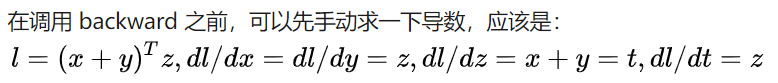

In [21]:
l.backward(retain_graph=True)
print(x.grad)
print(y.grad) # x.grad = y.grad = z
print(z)

print(z.grad) # z.grad = t = x + y
print(t)

tensor([ 1.3269, -2.0241, -0.8399])
tensor([ 1.3269, -2.0241, -0.8399])
tensor([ 1.3269, -2.0241, -0.8399], requires_grad=True)
tensor([0.2963, 0.5132, 0.7323])
tensor([0.2963, 0.5132, 0.7323], grad_fn=<AddBackward0>)


最后是本文的重点，**将z作为t.backward()的参数会怎么样？**按照前面手动求导的结果，dl/dt=z,正好和 PyTorch 的文档描述相符（variables 是 t，grad_variables 是 variables 的导数 dl/dt），根据分析，运行结果应该是损失函数 l 对 x 和 y 的导数:

In [22]:
x.grad.data.zero_()
y.grad.data.zero_()
z.grad.data.zero_()

t.backward(z)
print(x.grad)
print(y.grad)

tensor([ 1.3269, -2.0241, -0.8399])
tensor([ 1.3269, -2.0241, -0.8399])


实际运行的结果果然和 z （也就是 dl/dx 或者 dl/dy）的值一样：

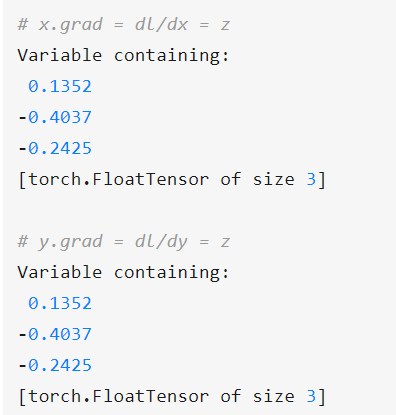

#### **实验三：** 再来看看 **中断梯度追踪**的例子：

In [12]:
x = torch.tensor(1.0,requires_grad=True)
y1 = x**2
with torch.no_grad():
    y2 = x**3
y3 = y1 + y2
print(x.requires_grad)
print(y1, y1.requires_grad) # True
print(y2, y2.requires_grad) # False
print(y3, y3.requires_grad) # True


True
tensor(1., grad_fn=<PowBackward0>) True
tensor(1.) False
tensor(2., grad_fn=<AddBackward0>) True


可以看到，上面的y2是没有grad_fn而且y2.requires_grad=False的，而y3是有grad_fn的。如果我们将y3对x求梯度的话会是多少呢？

In [13]:
y3.backward()
print(x.grad)


tensor(2.)


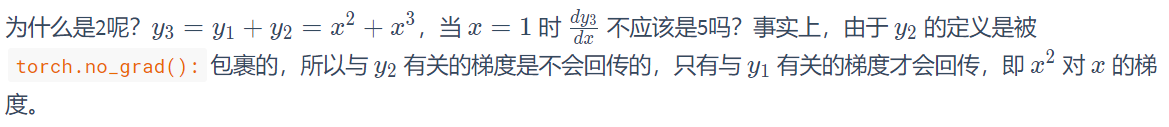

In [14]:
y2.backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

此外，如果我们想要修改tensor的数值，但是又不希望被autograd记录（即不会影响反向传播），那么我么可以对**tensor.data**进行操作。

In [15]:
x = torch.ones(1,requires_grad=True)

print(x.data) # 还是一个tensor
print(x.data.requires_grad) # 但是已经是独立于计算图之外

y = 2 * x
x.data *= 100 # 只改变了值，不会记录在计算图，所以不会影响梯度传播

y.backward()
print(x) # 更改data的值也会影响tensor的值
print(x.grad)


tensor([1.])
False
tensor([100.], requires_grad=True)
tensor([2.])


### 从投影方面理解 雅可比矩阵 pytorch自动微分

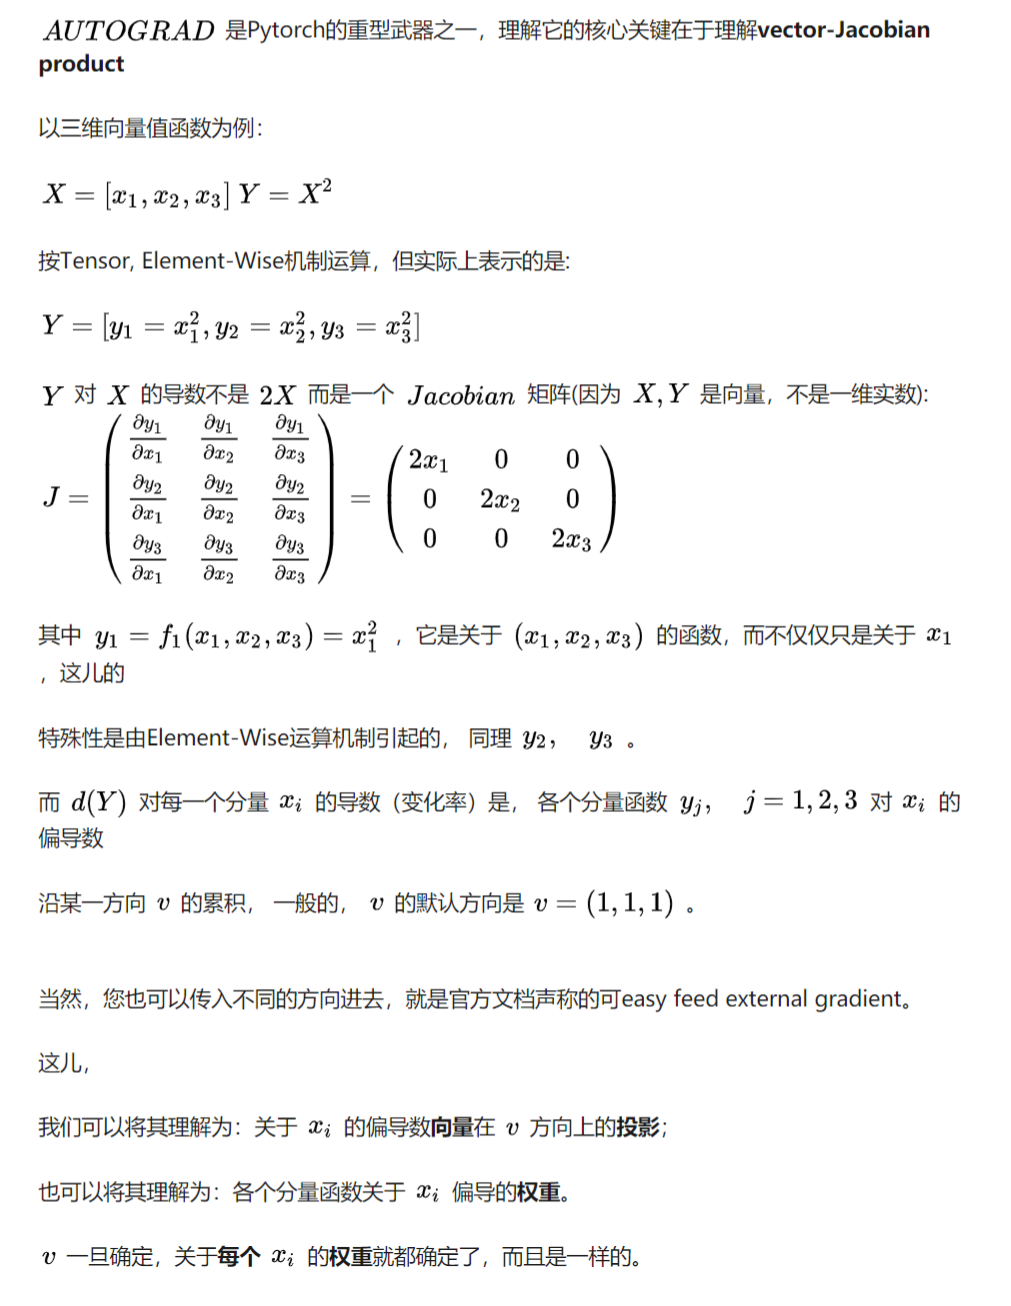

一。简单的隐式 jacobian

In [23]:
x = torch.randn(3,requires_grad = True)
x

tensor([-1.5383, -0.2821, -0.2916], requires_grad=True)

In [24]:
y = x**2
y.backward(torch.ones(3))
x.grad

tensor([-3.0765, -0.5643, -0.5832])

In [25]:
x

tensor([-1.5383, -0.2821, -0.2916], requires_grad=True)

二。简单的 jacobian验证

In [9]:
import torch
x1 = torch.tensor(1,requires_grad=False,dtype=torch.float)
x2 = torch.tensor(2,requires_grad=True,dtype=torch.float)
x3 = torch.tensor(3,requires_grad=True,dtype=torch.float)
y = torch.randn(3)

In [10]:
y

tensor([-1.0990, -1.1772, -1.3029])

In [11]:
y[0] = x1**2+2*x2+x3
y[1] = x1+x2**3+x3**2
y[2] = 2*x1+x2**2+x3**3

In [12]:
y.backward(torch.ones(3))

In [15]:
print(hasattr(x1,"grad"))
print(hasattr(x1,"grad.data"))
print(x1.grad)
print(x1.grad.data)

True
False
None


AttributeError: 'NoneType' object has no attribute 'data'

In [33]:
x2.grad

tensor(18.)

In [34]:
x3.grad

tensor(34.)

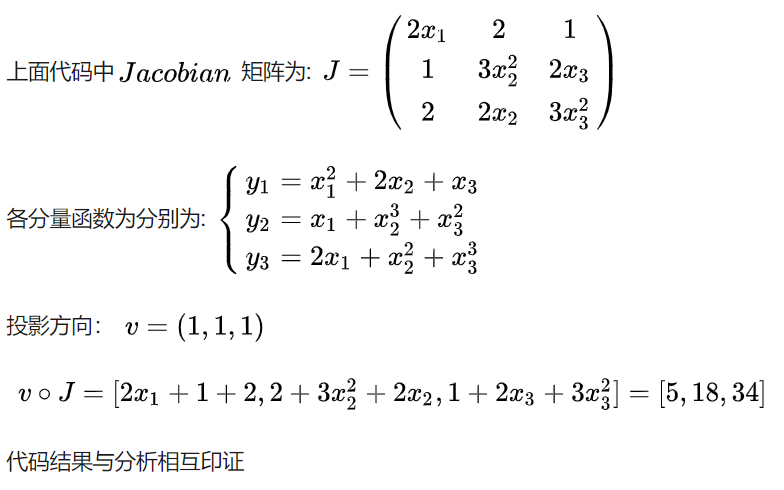